# Clustering spatial data

In [1]:
# Import modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


In [14]:
# Read spatial data
gdd = xr.load_dataarray('data/gdd_30_years.tif').squeeze()
precip = xr.load_dataarray('data/precip_30_years.tif').squeeze()
sand = xr.load_dataarray('data/sand_0_5_cm.tif').squeeze()

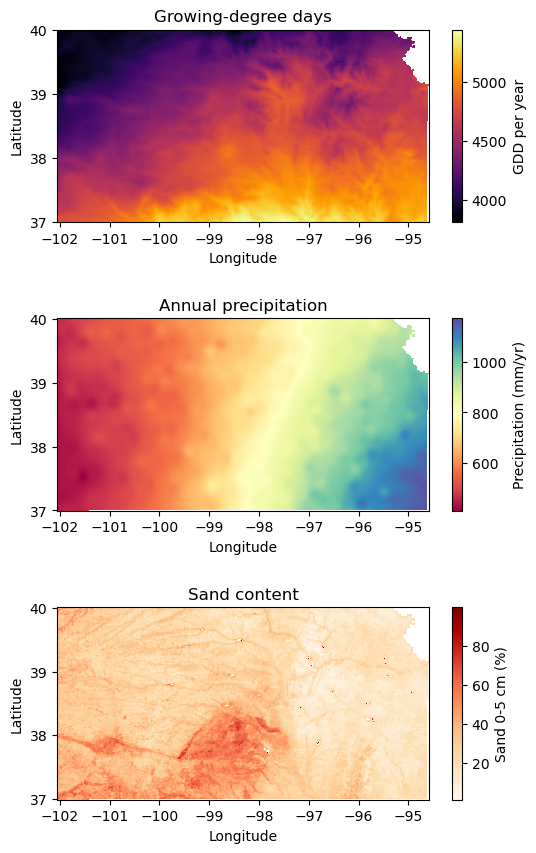

In [3]:
# Create figure to inspect each layer
plt.figure(figsize=(6, 10))

plt.subplot(3,1,1)
gdd.plot(cmap='inferno', cbar_kwargs={'label':'GDD per year'})
plt.title('Growing-degree days')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.axis('equal')

plt.subplot(3,1,2)
precip.plot(cmap='Spectral', cbar_kwargs={'label':'Precipitation (mm/yr)'})
plt.title('Annual precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
sand.plot(cmap='OrRd', cbar_kwargs={'label':'Sand 0-5 cm (%)'})
plt.title('Sand content')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplots_adjust(hspace=0.5)

plt.show()

In [5]:
# Convert 2D arrays into 1D arrays
X_gdd = gdd.data.flatten()
X_precip = precip.data.flatten()
X_sand = sand.data.flatten()

# Find pixels with NaN values in at least one feature
idx_nan = np.isnan(X_gdd) | np.isnan(X_precip) | np.isnan(X_sand)

# Replace the NaN values with mean value
X_gdd[idx_nan] = np.nanmean(X_gdd)
X_precip[idx_nan] = np.nanmean(X_precip)
X_sand[idx_nan] = np.nanmean(X_sand)

# Create aray of inputs ((n_samples by n_features))
X = np.column_stack( (X_gdd, X_precip, X_sand) )
X

array([[4595.71068024,  732.92663339,   27.33303631],
       [4595.71068024,  732.92663339,   27.33303631],
       [4595.71068024,  732.92663339,   27.33303631],
       ...,
       [4595.71068024,  732.92663339,   27.33303631],
       [4595.71068024,  732.92663339,   27.33303631],
       [4595.71068024,  732.92663339,   27.33303631]])

In [6]:
# Normalize data
# Default is L2: Euclidean norm, normalization that ensures that the sum of the squares of each row is 1
X_normalized = normalize(X, axis=0)

In [10]:
# Cluster using KMeans
clusters = KMeans(n_clusters=9, random_state=1, n_init='auto').fit(X_normalized)

In [11]:
# Convert to float so that we can bring back the NaN values
# to mask the resulting image
cluster_labels = clusters.labels_.astype(float)

# Restore mask
cluster_labels[idx_nan] = np.nan
cluster_labels = np.reshape(cluster_labels, sand.data.shape)
agro_regions = xr.DataArray(cluster_labels, coords=sand.coords, dims=sand.dims)


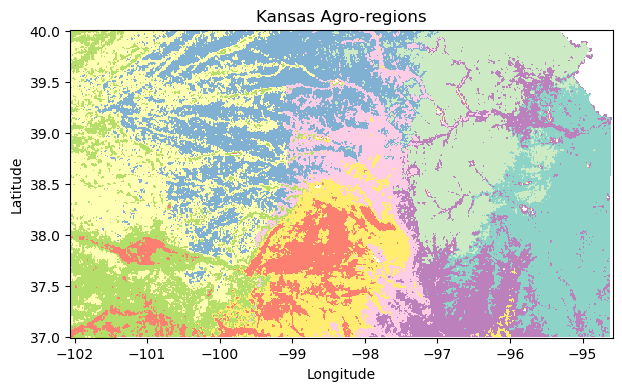

In [12]:
# Plot map (use the x and y coordinates from another layer since the cluster labels don't have coordinates)
fig, ax = plt.subplots(figsize=(7,4))
agro_regions.plot(ax=ax, cmap='Set3', add_colorbar=False)
plt.title('Kansas Agro-regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()